In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="colorblind6",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    "CPR": load_data("thermal_cpr", n_newest=NUM_SIMS),
    "Schur": load_data("thermal_schur", n_newest=NUM_SIMS),
    "Random": load_data("thermal_random", n_newest=NUM_SIMS),
    "Solver Selection": load_data("thermal_dynamic", n_newest=NUM_SIMS),

    # "Solver selection": load_data("thermal_dynamic", n_newest=NUM_SIMS),
    # "Standard exploration": load_data("../3_medium/thermal_eps_default", n_newest=NUM_SIMS)
}

save_media_path = Path('media')
save_media_path.mkdir(exist_ok=True)

COLORS = {
    'CPR': 'C0',
    'Schur': 'C1',
    'Solver Selection': 'C3',
    'Random': 'C4',
}

Loading data:
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_5.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_6.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_7.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_8.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_9.npy
Loading data:
/home/porepy/solver_selector/examples/1/performance/thermal_schur_5.npy
/home/porepy/solver_selector/examples/1/performance/thermal_schur_6.npy
/home/porepy/solver_selector/examples/1/performance/thermal_schur_7.npy
/home/porepy/solver_selector/examples/1/performance/thermal_schur_8.npy
/home/porepy/solver_selector/examples/1/performance/thermal_schur_9.npy
Loading data:
/home/porepy/solver_selector/examples/1/performance/thermal_random_5.npy
/home/porepy/solver_selector/examples/1/performance/thermal_random_6.npy
/home/porepy/solver_selector/examples/1/performance/thermal_random_7.npy
/home/porepy/solver_selector/

CPR 0.40439844131469727 0.0016489028930664062
CPR 0.40535863240559894 0.0037050247192382812
CPR 0.4050636887550354 0.0037050247192382812
CPR 0.40473475456237795 0.003859996795654297
Schur 0.4474637508392334 0.016194820404052734
Schur 0.4463406403859456 0.016194820404052734
Schur 0.44636303186416626 0.016194820404052734
Schur 0.4456140995025635 0.016194820404052734
Random 0.4024893045425415 0.08985066413879395
Random 0.41533152262369794 0.08985066413879395
Random 0.4126654267311096 0.08985066413879395
Random 0.41892595291137696 0.08985066413879395
Solver Selection 0.35079240798950195 0.0012421607971191406
Solver Selection 0.3804977734883626 0.0897371768951416
Solver Selection 0.39928293228149414 0.10546708106994629
Solver Selection 0.4081252574920654 0.10546708106994629


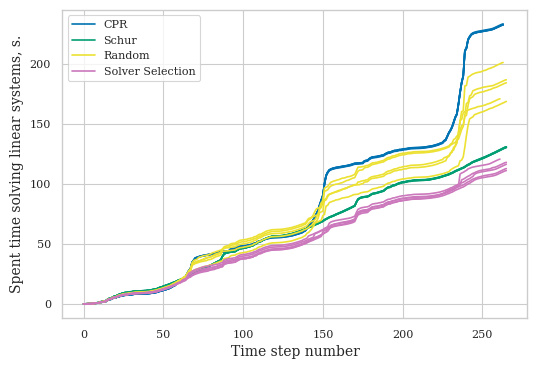

In [2]:
plt.figure(figsize=(6, 4))
for name, values in data.items():
    total = []
    make_label = True
    for perf in values:
        result = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )

        total.append(result[-1])
        result = np.cumsum(result)
        x = np.arange(len(result))
        if USE_SIMULATED_TIME:
            x = make_simulation_time(perf, converged=CONVERGED) / YEAR

        if make_label:
            plt.plot(x, result, color=COLORS[name], label=name)
            make_label = False
        else:
            plt.plot(x, result, color=COLORS[name])
            print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 232.48786664009094 0.8580594062805176
Schur 130.47565598487853 0.6475856304168701
Random 182.1571464061737 32.39318776130676
Solver Selection 115.65061569213867 9.544013738632202


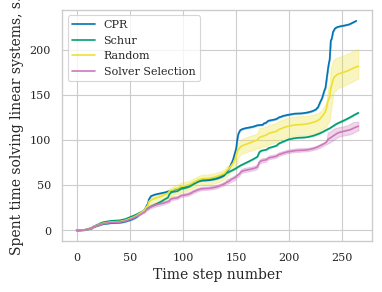

In [3]:
best_time = float('inf')
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR
Schur
Random
Solver Selection
Solver Selection (average)


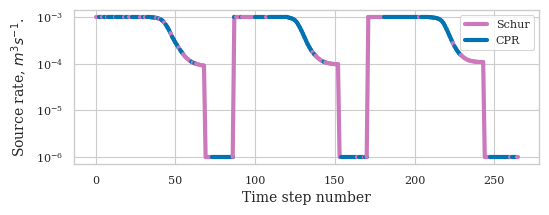

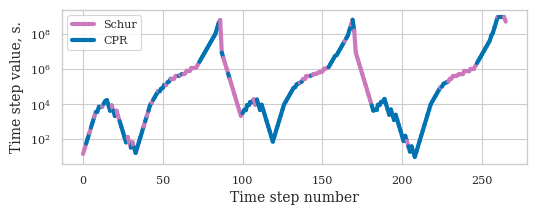

In [11]:
def color_using_schur(x, values, using_schur):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)
    cpr_color = "C0"
    schur_color = "C3"
    label_schur = False
    label_cpr = False

    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        if not using_schur[i]:
            kwargs = dict(color=cpr_color)
            if not label_cpr:
                kwargs["label"] = "CPR"
                label_cpr = True
        else:
            kwargs = dict(color=schur_color)
            if not label_schur:
                kwargs["label"] = "Schur"
                label_schur = True
        plt.plot(x_, val, linewidth=lw, **kwargs)
        plt.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def make_average_decision(values):
    return values[0]
    values = np.array(values, dtype=int)
    values = values.sum(axis=0)
    mean = NUM_SIMS / 2
    return values > mean


for name, vals in data.items():
    print(name)
    if name != 'Solver Selection':
        continue
    using_schur_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        using_schur_list.append(make_using_schur_indices(perf, converged=CONVERGED))
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    using_schur_mean = make_average_decision(using_schur_list)

    print(name, "(average)")
    plt.figure(figsize=(6, 2))
    color_using_schur(sim_time_list[0], inlet_rate_list[0], using_schur_mean)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel(X_LABEL)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_using_schur(sim_time_list[0], time_step_list[0], using_schur_mean)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()

CPR 0.40473475456237795 0.003859996795654297
Schur 0.4456140995025635 0.016194820404052734


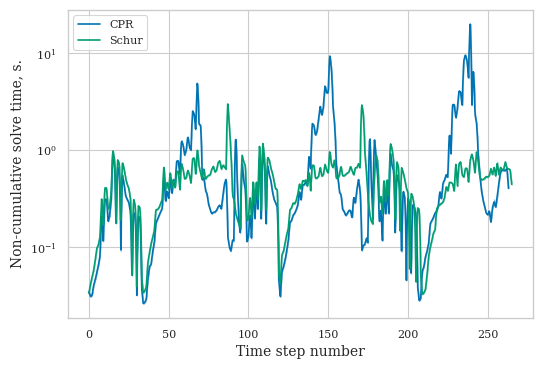

In [12]:
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []

    for perf in values:
        vals = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Non-cumulative solve time, s.")
plt.yscale('log')

CPR 86.0 0.0
Schur 40.0 0.0


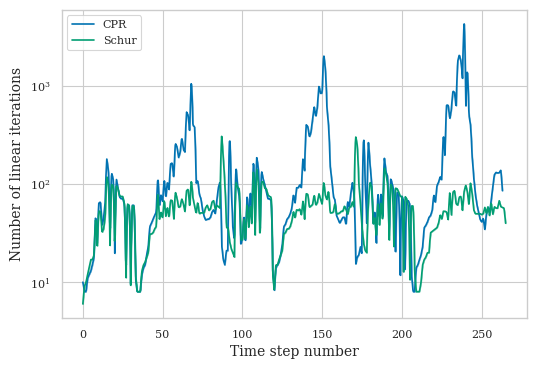

In [13]:
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []

    for perf in values:
        vals = sum_per_time_step(
            make_num_linear_iters(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Number of linear iterations")
plt.yscale('log')